# Latent Go-Explore for Franka Panda robtic arm 

Before you start, make sure you have the `panda-gym` package installed on the `no-task` branch. You can do this by running the following command:

```
pip install git+https://github.com/qgallouedec/panda-gym.git@no-task
```

In [1]:
import gym
import panda_gym
from stable_baselines3 import DDPG

from lge import LatentGoExplore

env = gym.make("PandaNoTask-v0", nb_objects=1)

lge = LatentGoExplore(
    DDPG,
    env,
    module_type="forward",
    latent_size=8,
    distance_threshold=1.0,
    lighten_dist_coef=0.0,
    p=0.001,
)

pybullet build time: Jul  9 2022 18:49:36


argv[0]=--background_color_red=0.8745098039215686
argv[1]=
argv[2]=
argv[3]=
argv[4]=
argv[5]=
argv[6]=
argv[7]=
argv[8]=
argv[9]=
argv[10]=
argv[11]=
argv[12]=
argv[13]=
argv[14]=
argv[15]=
argv[16]=
argv[17]=
argv[18]=
argv[19]=
argv[20]=
argv[21]=--background_color_green=0.21176470588235294
argv[22]=
argv[23]=
argv[24]=
argv[25]=
argv[26]=
argv[27]=
argv[28]=
argv[29]=
argv[30]=
argv[31]=
argv[32]=
argv[33]=
argv[34]=
argv[35]=
argv[36]=
argv[37]=
argv[38]=
argv[39]=
argv[40]=
argv[41]=
argv[42]=--background_color_blue=0.17647058823529413


Then, make LGE explore for 200k timesteps.

In [2]:
num_timesteps = 200_000
lge.explore(num_timesteps)

## Plotting the results

We compute the coverage. Fist, we need to get all the observations.

In [3]:
import numpy as np

observations = lge.replay_buffer.next_observations["observation"][:num_timesteps]

# `observations` has the shape (num_timesteps x num_envs x obs_shape) with num_env = 1.
# So we squeeze `observations` so that it has a shape of (num_timesteps x obs_shape).
observations = np.squeeze(observations)

Then, we compute the number of bins of size 0.1 x 0.1 explored.

In [4]:
bins = np.floor(observations / 0.1)  # Divide the space into 0.1 x 0.1 bins.
unique, bin_uids = np.unique(bins, axis=0, return_inverse=True)  # Each bin has its own UID

explored_uid_so_far = []
nb_bins = np.zeros(num_timesteps)
for t in range(num_timesteps):
    bin_uid = bin_uids[t]
    if not bin_uid in explored_uid_so_far:
        explored_uid_so_far.append(bin_uid)
    nb_bins[t] = len(explored_uid_so_far)

Now, we can plot the number of bins explored through timesteps.

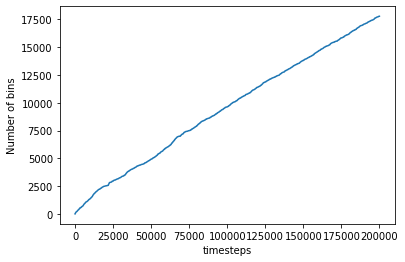

In [5]:
import matplotlib.pyplot as plt

plt.xlabel("timesteps")
plt.ylabel("Number of bins")
plt.plot(nb_bins)

Now we want to see what the latent space looks like. To do this, we will plot all the latent representations we encounter as scatter plots. The color of these points gives the probability that the corresponding observation is sampled as a goal.

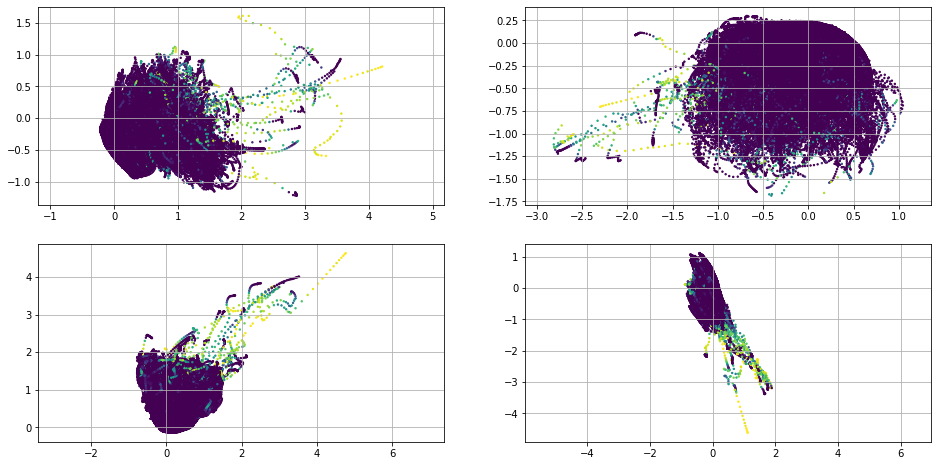

In [6]:
# Some borring lines to get the probability of each observation to be sampled as goal
lge.replay_buffer.recompute_embeddings()
embeddings = lge.replay_buffer.next_embeddings[:num_timesteps]
embeddings = np.squeeze(embeddings)
sorted_density = lge.replay_buffer.sorted_density[:num_timesteps]
_, index = np.unique(sorted_density, return_index=True)
p = lge.replay_buffer.p
prob = (1 - p) ** (np.arange(num_timesteps) - 1) * p
prob = prob[index]

# Get a color map to render this probability
cmap = plt.get_cmap()
color = cmap(prob / prob.max())

fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)  # increase size, for readibility
fig.set_figwidth(16)

# Plot latent space
for row in range(2):
    for col in range(2):
        axs[row, col].grid()
        axs[row, col].axis("equal")
        latent_idx = 2 * (2 * row + col)
        axs[row, col].scatter(*embeddings[:, latent_idx : latent_idx + 2].T, c=color, s=2)

We can do the same for observations.

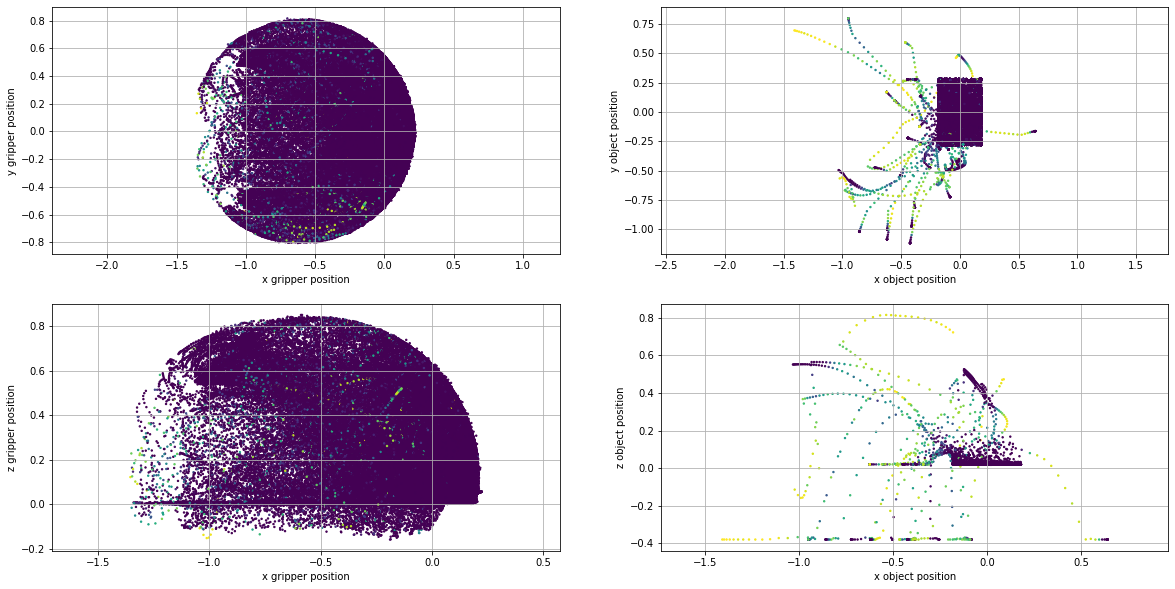

In [7]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(20)

axs[0, 0].grid()
axs[0, 0].axis("equal")
axs[0, 0].set_xlabel("x gripper position")
axs[0, 0].set_ylabel("y gripper position")
axs[0, 0].scatter(*observations[:, [0, 1]].T, c=color, s=2)

axs[1, 0].grid()
axs[1, 0].axis("equal")
axs[1, 0].set_xlabel("x gripper position")
axs[1, 0].set_ylabel("z gripper position")
axs[1, 0].scatter(*observations[:, [0, 2]].T, c=color, s=2)

axs[0, 1].grid()
axs[0, 1].axis("equal")
axs[0, 1].set_xlabel("x object position")
axs[0, 1].set_ylabel("y object position")
axs[0, 1].scatter(*observations[:, [4, 5]].T, c=color, s=2)

axs[1, 1].grid()
axs[1, 1].axis("equal")
axs[1, 1].set_xlabel("x object position")
axs[1, 1].set_ylabel("z object position")
axs[1, 1].scatter(*observations[:, [4, 6]].T, c=color, s=2)

In [8]:
traj, _ = lge.replay_buffer.sample_trajectory()
traj = traj.round(1)

print("Gripper trajectory")
print(traj[..., 0:3])
print("Object trajetcory")
print(traj[..., 4:7])

Gripper trajectory
[[-0.2  0.   0.2]
 [-0.6 -0.7  0.4]]
Object trajetcory
[[-0.1  0.1  0. ]
 [-0.1  0.1  0. ]]
